1.(한 것 중에) 더 해야 되는 것
-eda 합치기

2.(한 것 중에) 더 하면 좋은 것

-eda 추가  <- 윤정) 이거 에러 나는 거 고치기!
-feature extraction permutation, SHAP 방법

-matplotlib -> seaborn


In [ ]:
%matplotlib inline

In [ ]:
#!pip install scattertext

In [ ]:
#!pip install wordcloud

In [ ]:
#!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import time
import re
import nltk
import seaborn as sns
#nltk.download('wordnet')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

#visualization
from matplotlib import pyplot as plt
#import scattertext
#from wordcloud import WordCloud, STOPWORDS

#tokenization
from nltk.tokenize import TreebankWordTokenizer
#Lemmatization
from nltk.stem import WordNetLemmatizer
#Stemming
from nltk.stem import PorterStemmer

#vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
#if-then-else rules
from sklearn import tree
from sklearn.tree import _tree

#creating batches
import itertools

#rf feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

#rf classifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#explian results
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

EDA

Task 1

In [ ]:
directory_location = 'G:/My Drive/IDS finals/data/'

In [ ]:
control_df = pd.read_csv(directory_location + 'IDS_control_data_set.tsv', sep = '\t')
treatment_df =pd.read_csv(directory_location + 'IDS_treatment_data_set.tsv', sep = '\t')
key_paper = pd.read_csv(directory_location + 'team1 - keypaper - Copy.tsv', sep = '\t')

In [ ]:
print(control_df.shape)
print(treatment_df.shape)
print(key_paper.shape)

(23089, 27)
(26486, 27)
(1, 9)


In [ ]:
control_df = control_df.dropna(subset=['keywords']) #for Task 1-1
treatment_df = treatment_df.dropna(subset=['keywords']) #forTask 1-1
control_df = control_df.dropna(subset=['abstract']) #for Task 1-2
treatment_df = treatment_df.dropna(subset=['abstract']) #forTask 1-2

In [ ]:
control_df.insert(0,'category', 0) #on the first col for easy extraction later
treatment_df.insert(0,'category',1)

In [ ]:
#entire features
print(control_df.shape)
print(treatment_df.shape)

(22978, 28)
(26468, 28)


In [ ]:
df = pd.concat([control_df, treatment_df], join = 'inner', ignore_index = True)
df.shape 

(49446, 28)

In [ ]:
df.columns

Index(['category', 'type_of_reference', 'title', 'custom3', 'alternate_title1',
       'volume', 'number', 'year', 'doi', 'issn', 'authors', 'author_address',
       'abstract', 'keywords', 'secondary_authors', 'publisher',
       'secondary_title', 'access_date', 'notes', 'type_of_work',
       'name_of_database', 'custom7', 'language', 'subsidiary_authors', 'url',
       'start_page', 'end_page', 'place_published'],
      dtype='object')

In [ ]:
#control_df = control_df.head(1000) #extracting 1000 cuz gcp vm instance failed
#treatment_df = treatment_df.head(1000)

In [ ]:
#viewing length of keyword sequence for each references
kw_length = df['keywords'].apply(len)
kw_length.head()

0    112
1    216
2    245
3    208
4    351
Name: keywords, dtype: int64

<ipython-input-16-bd0f2ff2ef2a>:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


Text(0, 0.5, 'Number of keywords')

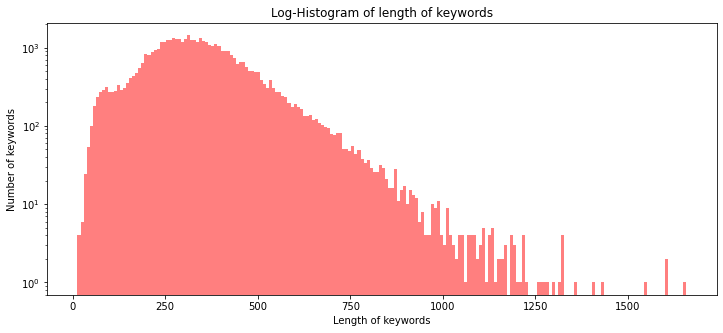

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(kw_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of keywords')
plt.xlabel('Length of keywords')
plt.ylabel('Number of keywords')

In [ ]:
print('maximum keyword length: {}'.format(np.max(kw_length))) 
print('minimum keyword length: {}'.format(np.min(kw_length)))
print('average keyword length: {:.2f}'.format(np.mean(kw_length)))
print('standard deviation: {:.2f}'.format(np.std(kw_length)))
print('median keyword length: {}'.format(np.median(kw_length)))
print('first quartile: {}'.format(np.percentile(kw_length, 25)))
print('third quartile: {}'.format(np.percentile(kw_length, 75)))

maximum keyword length: 1657
minimum keyword length: 13
average keyword length: 343.96
standard deviation: 147.80
median keyword length: 327.0
first quartile: 248.0
third quartile: 420.0


{'whiskers': [<matplotlib.lines.Line2D at 0x27625af1f70>,
 'caps': [<matplotlib.lines.Line2D at 0x27625afc670>,
 'boxes': [<matplotlib.lines.Line2D at 0x27625af1c10>],
 'medians': [<matplotlib.lines.Line2D at 0x27625afcd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x27625b05430>],
 'means': [<matplotlib.lines.Line2D at 0x27625b050d0>]}

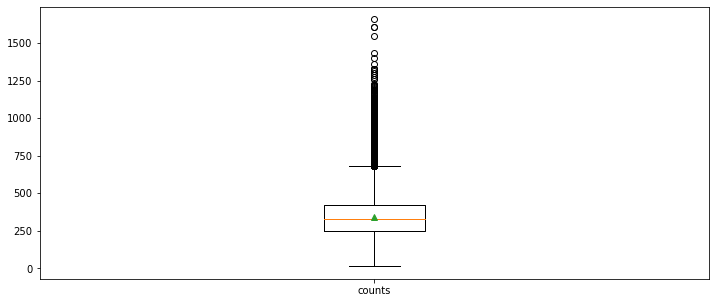

In [ ]:
plt.figure(figsize=(12,5))
plt.boxplot(kw_length, labels=['counts'], showmeans=True)

In [ ]:
#df for keywords
df_kw = df.loc[ : , ['category', 'keywords']]
print(df_kw.shape)

(49446, 2)


In [ ]:
df_kw.head()

,category,keywords
0,0,Ethylene;Neural networks;Cracking process;Neur...
1,0,Essential oils;Extraction;Particle size;Superc...
2,0,Autoclaves;Monomers;Polymerization;Initiator c...
3,0,Computer software;Cracks;Ethane;Ethylene;Crack...
4,0,Chromatography;Glucose;High performance liquid...


In [ ]:
#save df_kw to txt file in directory_location
df_kw_array = df_kw.to_numpy()
np.savetxt(directory_location + 'df_kw.txt', df_kw_array, fmt = '%s', encoding = 'UTF-8')

In [ ]:
#df for abstracts
df_abs = df.loc[ : , ['category', 'abstract']]
print(df_abs.shape)

(49446, 2)


In [ ]:
df_abs.head()

,category,abstract
0,0,Cracking process is a very important process t...
1,0,Swietenia mahagoni (Mahogany) is a traditional...
2,0,Low-density polyethylene (LDPE) is one of the ...
3,0,Understanding the influence of operating param...
4,0,A solution model consisted of two different mo...


In [ ]:
#save df_abs to txt file in directory_location
df_abs_array = df_abs.to_numpy()
np.savetxt(directory_location + 'df_abs.txt', df_abs_array, fmt = '%s', encoding = 'UTF-8')
df_abs.to_csv(directory_location + 'df_abs.tsv', sep  = '\t')

task 1.1 keyword: corpus, feature extraction, if-then-else rules

In [ ]:

#for line in df_kw.readlines():
#  line = line.replace("\n", " ") #each line
#  parsed_by_space = line.split()
#  wordlist = " ".join(parsed_by_space[1:])
#  wordlist = wordlist.replace(";", " ").split()
#  wordlist = " ".join(wordlist[:])
#  print(wordlist)

In [ ]:
df_kw = open(directory_location + 'df_kw.txt', "r", encoding = 'UTF-8')

In [ ]:
#numbers = "12 34 56"
#result = numbers.split() #split by ws
#print(result)

In [ ]:
id_list = []
control_treatment_list = []
wordlist_list = []

count = 0
for line in df_kw.readlines():
  line = line.replace("\n", " ") #\n to white space
  count = count + 1  
  id_list.append(count)

  parsed_by_space = line.split() # parsing each line with space 

  control_treatment = parsed_by_space[0]
  control_treatment_list.append(control_treatment)
    
  wordlist = " ".join(parsed_by_space[1:])
  shortword = re.compile(r'\W*\b\w{1,2}\b')
  wordlist = shortword.sub("", wordlist)
  wordlist = " ".join(parsed_by_space[1:])
  wordlist = wordlist.replace(";", " ").split()
  wordlist = " ".join(wordlist[:])
 #remove shortwords of 1,2 alphabet
 # wordlist = [word.split(';') for word in wordlist]
 # wordlist_list.append(wordlist)
  wordlist_list.append(wordlist)

print("#data points: ", count, " .")
corpus1 = wordlist_list

#data points:  49446  .


In [ ]:
corpus1

['Ethylene Neural networks Cracking process Neural network modelling Nonlinear techniques Reaction network Cracks',
 'Essential oils Extraction Particle size Supercritical fluid extraction Bioactive compounds Constant pressures Extraction time Process parameters Supercritical carbon dioxides Temperature and pressures Carbon dioxide',
 'Autoclaves Monomers Polymerization Initiator concentration Low density polyethylene(LDPE) Monomer conversions Polymerization rates Polymerization reaction Product specifications Reactor temperatures Steady-state mathematical model Polyethylenes',
 'Computer software Cracks Ethane Ethylene Cracking furnace Cracking severity Operating parameters Optimum operations Outlet temperature Process performance Reactor temperatures Simulation model Steam cracking',
 'Chromatography Glucose High performance liquid chromatography Liquid chromatography Membranes Molecules Nanofiltration Thermomechanical pulping process Chromatographic process Cross flow parameter Feed

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
corpus1 = [lemmatizer.lemmatize(list_num) for list_num in corpus1]
corpus1 = [stemmer.stem(list_num) for list_num in corpus1]

lemmatized, stemmed corpus 

In [ ]:
corpus1

['ethylene neural networks cracking process neural network modelling nonlinear techniques reaction network crack',
 'essential oils extraction particle size supercritical fluid extraction bioactive compounds constant pressures extraction time process parameters supercritical carbon dioxides temperature and pressures carbon dioxid',
 'autoclaves monomers polymerization initiator concentration low density polyethylene(ldpe) monomer conversions polymerization rates polymerization reaction product specifications reactor temperatures steady-state mathematical model polyethylen',
 'computer software cracks ethane ethylene cracking furnace cracking severity operating parameters optimum operations outlet temperature process performance reactor temperatures simulation model steam crack',
 'chromatography glucose high performance liquid chromatography liquid chromatography membranes molecules nanofiltration thermomechanical pulping process chromatographic process cross flow parameter feed concen

In [ ]:
tv_binary = TfidfVectorizer(
    binary=True, norm=False, 
    use_idf=False, smooth_idf=False, 
    lowercase=True, stop_words='english', 
    min_df=1, max_df=1.0, 
    max_features=None, ngram_range=(1, 1)).fit(corpus1)

In [ ]:
DTM = tv_binary.transform(corpus1)
DTM = DTM.astype('float32')
df_kw = pd.DataFrame(DTM.toarray(), columns=tv_binary.get_feature_names()) #!! 성공! 메모리 에러 안남!!

vectorized corpus to DataFrame

In [ ]:
df_kw.head()

,001,01,010,0110,0113,0157,0170,02,0290,02c,...,μtas,μvpp,τf,χ2,ℓ1,ﬁber,ﬁeld,ﬁnite,ﬂexural,ﬂow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_kw['category'].value_counts()

0.0    49441
1.0        5
Name: category, dtype: int64

In [ ]:
df_kw['category'] == 1

0        False
1        False
2        False
3        False
4        False
         ...  
49441    False
49442    False
49443    False
49444    False
49445    False
Name: category, Length: 49446, dtype: bool

In [ ]:
temp = sorted(tv_binary.vocabulary_.items(), reverse=True) #tfidf 단어사전 정렬 내림차순

Sample top 1000 tfidf to perform rf for feature extraction for memory purposes

In [ ]:
extract = temp[:1000] #just sample these 1000 features #dtype: list
print(extract)

[('ﬂow', 33712), ('ﬂexural', 33711), ('ﬁnite', 33710), ('ﬁeld', 33709), ('ﬁber', 33708), ('ℓ1', 33707), ('χ2', 33706), ('τf', 33705), ('μvpp', 33704), ('μtas', 33703), ('μspr', 33702), ('μs', 33701), ('μpiv', 33700), ('μpads', 33699), ('μmri', 33698), ('μm', 33697), ('μled', 33696), ('μecog', 33695), ('μct', 33694), ('μc', 33693), ('μa', 33692), ('λmax', 33691), ('κb', 33690), ('ζfcs', 33689), ('εsubunit', 33688), ('δψ', 33687), ('δvfb', 33686), ('βfilt', 33685), ('β2m', 33684), ('β2', 33683), ('β1', 33682), ('αvβ3', 33681), ('αvß3', 33680), ('αindex', 33679), ('ěrenkov', 33678), ('čerenkov', 33677), ('étendue', 33676), ('zynq', 33675), ('zymosan', 33674), ('zygotes', 33673), ('zy', 33672), ('zwitterionic', 33671), ('zwitterion', 33670), ('zvt', 33669), ('zvs', 33668), ('zvrt', 33667), ('zte', 33666), ('zt', 33665), ('zsm', 33664), ('zsi', 33663), ('zrw2o8', 33662), ('zro2', 33661), ('zro', 33660), ('zrn', 33659), ('zrb2', 33658), ('zr', 33657), ('zp', 33656), ('zoroastrian', 33655), (

In [ ]:
extract = [i[0] for i in extract]
print(extract)

['ﬂow', 'ﬂexural', 'ﬁnite', 'ﬁeld', 'ﬁber', 'ℓ1', 'χ2', 'τf', 'μvpp', 'μtas', 'μspr', 'μs', 'μpiv', 'μpads', 'μmri', 'μm', 'μled', 'μecog', 'μct', 'μc', 'μa', 'λmax', 'κb', 'ζfcs', 'εsubunit', 'δψ', 'δvfb', 'βfilt', 'β2m', 'β2', 'β1', 'αvβ3', 'αvß3', 'αindex', 'ěrenkov', 'čerenkov', 'étendue', 'zynq', 'zymosan', 'zygotes', 'zy', 'zwitterionic', 'zwitterion', 'zvt', 'zvs', 'zvrt', 'zte', 'zt', 'zsm', 'zsi', 'zrw2o8', 'zro2', 'zro', 'zrn', 'zrb2', 'zr', 'zp', 'zoroastrian', 'zooms', 'zooming', 'zoom', 'zoochlorellae', 'zoning', 'zones', 'zone', 'zonal', 'zona', 'zon', 'zoledronic', 'zohair', 'znte', 'znses', 'znse', 'zns', 'zno', 'znmgo', 'zngep2', 'znfe2o4', 'zncr2o4', 'zncds', 'znal', 'zn0', 'zn', 'zmp', 'zk60', 'zizanioides', 'ziv', 'zirconiums', 'zirconium', 'zirconias', 'zirconia', 'zirconates', 'zirconate', 'zircon', 'zircaloy', 'zipper', 'zip', 'zingiber', 'zindo', 'zincs', 'zincating', 'zincate', 'zinc', 'zijdenbos', 'zigzag', 'zigbee', 'zigbe', 'zig', 'ziegler', 'zhuhai', 'zhong

In [ ]:
print(len(extract))

1000


In [ ]:
df_kw[['flow']]

,flow
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
49441,0.0
49442,0.0
49443,0.0
49444,0.0


In [ ]:
def extract_df_kw():
    dat = pd.DataFrame(columns = range(1))
    for i in extract:
        dat = pd.concat([dat, df_kw[[i]]], axis = 1)
    return dat

In [ ]:
extract_df_kw  = extract_df_kw()

In [ ]:
extract_df_kw.head()

,0,ﬂow,ﬂexural,ﬁnite,ﬁeld,ﬁber,ℓ1,χ2,τf,μvpp,...,viscos,viscoplasticity,viscoplastic,viscometry,viscometers,viscometer,viscoelasto,viscoelasticity,viscoelasticities,viscoelastic
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
del extract_df_kw[0]
extract_df_kw.head()

,ﬂow,ﬂexural,ﬁnite,ﬁeld,ﬁber,ℓ1,χ2,τf,μvpp,μtas,...,viscos,viscoplasticity,viscoplastic,viscometry,viscometers,viscometer,viscoelasto,viscoelasticity,viscoelasticities,viscoelastic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
extract_df_kw.shape

(49446, 1000)

In [ ]:
df_kw['category']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
49441    0.0
49442    0.0
49443    0.0
49444    0.0
49445    0.0
Name: category, Length: 49446, dtype: float32

In [ ]:
extract_df_kw_data = extract_df_kw[extract_df_kw.columns.difference(['category'])]
extract_df_kw_target = control_treatment_list

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(extract_df_kw_data, extract_df_kw_target, test_size = 0.20, random_state=42)

In [ ]:
extract_df_kw_data.columns

Index(['viscoelastic', 'viscoelasticities', 'viscoelasticity', 'viscoelasto',
       'viscometer', 'viscometers', 'viscometry', 'viscoplastic',
       'viscoplasticity', 'viscos',
       ...
       'μtas', 'μvpp', 'τf', 'χ2', 'ℓ1', 'ﬁber', 'ﬁeld', 'ﬁnite', 'ﬂexural',
       'ﬂow'],
      dtype='object', length=1000)

In [ ]:
feature_names = [f'feature {i}' for i in range(extract_df_kw_data.shape[1])] #뒤에 새 데이터 뽑을 때 유의
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
feature_importance_table = {} # a dict to hold feature_name: feature_importance
#for feature, importance in zip(data.columns, model.feature_importances_):
for feature, importance in zip(feature_names, forest.feature_importances_):
    feature_importance_table[feature] = importance #add the name/value pair 

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.046 seconds


In [ ]:
import pandas as pd
forest_importances = pd.Series(importances, index=feature_names)

In [ ]:
forest_importances.sort_values(ascending=False)

feature 56     0.088600
feature 30     0.044487
feature 533    0.035953
feature 325    0.034290
feature 429    0.033575
                 ...   
feature 166    0.000000
feature 614    0.000000
feature 613    0.000000
feature 480    0.000000
feature 791    0.000000
Length: 1000, dtype: float64

In [ ]:
k= 5
topk_forest_importances = forest_importances.sort_values(ascending=False).iloc[:k]

In [ ]:
topk_forest_importances #top 5 important features

feature 56     0.088600
feature 30     0.044487
feature 533    0.035953
feature 325    0.034290
feature 429    0.033575
dtype: float64

In [ ]:
topk_forest_importances.index[0]

'feature 56'

In [ ]:
names = list(extract_df_kw_data.columns.values)

In [ ]:
print(names)

['viscoelastic', 'viscoelasticities', 'viscoelasticity', 'viscoelasto', 'viscometer', 'viscometers', 'viscometry', 'viscoplastic', 'viscoplasticity', 'viscos', 'viscose', 'viscosimetry', 'viscosities', 'viscosity', 'viscous', 'viseme', 'visibilities', 'visibility', 'visible', 'visiometric', 'vision', 'visions', 'visitor', 'visits', 'vissim', 'vistaproof', 'vistula', 'visu', 'visual', 'visualisation', 'visualization', 'visualizations', 'visually', 'visuals', 'visuo', 'visuomotor', 'visuospatial', 'vital', 'vitalities', 'vitality', 'vitamin', 'vitamins', 'viterbi', 'vitesse', 'vitiligo', 'vitis', 'vitreoretinal', 'vitreoretinopathy', 'vitreous', 'vitrif', 'vitrification', 'vitrinite', 'vitro', 'viusal', 'vivaldi', 'vive', 'vivo', 'vivosight', 'vlad', 'vlaser', 'vlbi', 'vlc', 'vle', 'vliw', 'vlp', 'vlsi', 'vm', 'vmgcs', 'vna', 'vne', 'vnir', 'vns', 'vo', 'voc', 'vocabularies', 'vocabulary', 'vocal', 'vocalization', 'vocational', 'vocoder', 'vocs', 'vof', 'vofdm', 'vogel', 'voi', 'voice', 

In [ ]:
k_feature_names = []

i = 0
for index in topk_forest_importances.index:  
  id = index
  index = index.split()[1]
  index = int(index)
  k_feature_names.append(names[index])
  print(id, names[index], topk_forest_importances[i])
  i = i + 1

feature 56 vivo 0.08859960992295834
feature 30 visualization 0.044486755771277656
feature 533 wind 0.03595276027940239
feature 325 wavelength 0.0342900310859408
feature 429 welding 0.03357488959221561


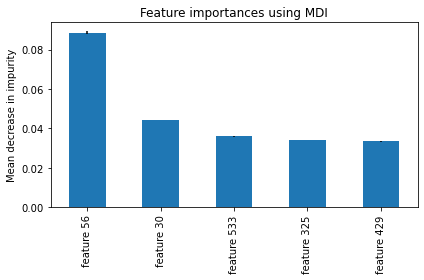

In [ ]:
fig, ax = plt.subplots()
topk_forest_importances.plot.bar(yerr=std[:k], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
new_colnames = topk_forest_importances.index.to_list()

In [ ]:
new_colnames

['feature 56', 'feature 30', 'feature 533', 'feature 325', 'feature 429']

In [ ]:
new_colnames = [18, 325, 287, 61, 312]

In [ ]:
def df_data_new():
    dat = pd.DataFrame(columns = range(1))
    for i in new_colnames:
        dat = pd.concat([dat, extract_df_kw_data.iloc[ :,i]], axis = 1)
    return dat

In [ ]:
df_data_new = df_data_new()

In [ ]:
del df_data_new[0]
df_data_new #feature extraction 성공 !!!

,visible,wavelength,water,vlc,wave
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
49441,0.0,0.0,0.0,0.0,0.0
49442,0.0,0.0,0.0,0.0,0.0
49443,0.0,0.0,0.0,0.0,0.0
49444,0.0,0.0,0.0,0.0,1.0


In [ ]:
#save df_abs to txt file in directory_location
df_new_array = df_data_new.to_numpy()
np.savetxt(directory_location + 'df_data_new.txt', df_new_array, fmt = '%s', encoding = 'UTF-8')

Decision Tree, rule extraction from sampled & feature extracted dataset

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X = df_data_new
y = control_treatment_list
clf = DecisionTreeClassifier(max_depth = 3, random_state = 1234)
model = clf.fit(X,y)

In [ ]:
df_data_new.shape

(49446, 5)

In [ ]:
y = np.array(y)
y

array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U1')

In [ ]:
ddn_array = np.array(df_data_new)
ddn_array

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
feature_names = ['visible', 'wavelength', 'water', 'vlc', 'wave']
feature_names

['visible', 'wavelength', 'water', 'vlc', 'wave']

In [ ]:
data_whole = {'data' : ddn_array, 'feature_names' : feature_names, 'target' : y}
data_whole

{'data': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]], dtype=float32),
 'feature_names': ['visible', 'wavelength', 'water', 'vlc', 'wave'],
 'target': array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U1')}

In [ ]:
#built-in text representation
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_1 <= 0.50
|   |--- feature_2 <= 0.50
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_4 >  0.50
|   |   |   |--- class: 1
|   |--- feature_2 >  0.50
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_4 >  0.50
|   |   |   |--- class: 1
|--- feature_1 >  0.50
|   |--- feature_2 <= 0.50
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_4 >  0.50
|   |   |   |--- class: 1
|   |--- feature_2 >  0.50
|   |   |--- class: 1



In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
data_whole

{'data': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]], dtype=float32),
 'feature_names': ['visible', 'wavelength', 'water', 'vlc', 'wave'],
 'target': array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U1')}

In [ ]:
data_whole['feature_names']

['visible', 'wavelength', 'water', 'vlc', 'wave']

In [ ]:
# human-friendly rules
rules = get_rules(clf, data_whole['feature_names'], data_whole['target'])
for r in rules:
    print(r)

if (wavelength <= 0.5) and (water <= 0.5) and (wave <= 0.5) then class: 0 (proba: 53.02%) | based on 45,769 samples
if (wavelength <= 0.5) and (water <= 0.5) and (wave > 0.5) then class: 0 (proba: 74.06%) | based on 1,430 samples
if (wavelength <= 0.5) and (water > 0.5) and (wave <= 0.5) then class: 0 (proba: 74.39%) | based on 1,355 samples
if (wavelength > 0.5) and (water <= 0.5) and (wave <= 0.5) then class: 0 (proba: 89.86%) | based on 730 samples
if (wavelength > 0.5) and (water <= 0.5) and (wave > 0.5) then class: 0 (proba: 86.9%) | based on 84 samples
if (wavelength <= 0.5) and (water > 0.5) and (wave > 0.5) then class: 0 (proba: 75.0%) | based on 40 samples
if (wavelength > 0.5) and (water > 0.5) then class: 0 (proba: 100.0%) | based on 38 samples


Comparison of performances on partial classifiers on 
original data (df_kw) vs. feature extracted data (df_data_new)

In [ ]:
df_kw_csv = pd.read_csv(directory_location + '/df_kw.txt', sep = '\n', header = None)

In [ ]:
df_kw_csv

,0
0,0 Ethylene;Neural networks;Cracking process;Ne...
1,0 Essential oils;Extraction;Particle size;Supe...
2,0 Autoclaves;Monomers;Polymerization;Initiator...
3,0 Computer software;Cracks;Ethane;Ethylene;Cra...
4,0 Chromatography;Glucose;High performance liqu...
...,...
49441,1 Cross correlation;Depth measurement;Fundus i...
49442,1 Google Glass;Healthcare;Optical Coherence To...
49443,1 Carbon dioxide laser;Caries prevention;Erosi...
49444,1 Coherent Back-Scattering (CBS);Coherent pola...


In [ ]:
df_kw_csv = df_kw_csv[0]

In [ ]:
df_kw_csv

0        0 Ethylene;Neural networks;Cracking process;Ne...
1        0 Essential oils;Extraction;Particle size;Supe...
2        0 Autoclaves;Monomers;Polymerization;Initiator...
3        0 Computer software;Cracks;Ethane;Ethylene;Cra...
4        0 Chromatography;Glucose;High performance liqu...
                               ...                        
49441    1 Cross correlation;Depth measurement;Fundus i...
49442    1 Google Glass;Healthcare;Optical Coherence To...
49443    1 Carbon dioxide laser;Caries prevention;Erosi...
49444    1 Coherent Back-Scattering (CBS);Coherent pola...
49445    1 Adaptive grid;Classification;Layer segmentat...
Name: 0, Length: 49446, dtype: object

In [ ]:
#m = [lemmatizer.lemmatize(list_num) for list_num in df_kw_csv]
m = [stemmer.stem(list_num) for list_num in df_kw_csv]

In [ ]:
m[0] #lemmatized and stemmed

'0 ethylene;neural networks;cracking process;neural network modelling;nonlinear techniques;reaction network;cracks;'

In [ ]:
def stream_documents(df_kw_csv):
    global m
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    for doc_num in range(len(df_kw_csv)):
        m = re.search(r'(\d)\s(.+)', df_kw_csv[doc_num])
        cls, body = m.group(1), m.group(2)
        shortword = re.compile(r'\W*\b\w{1,2}\b')
        body = shortword.sub("", body)
        body = body.replace(";", " ")
        doc = {'cls': cls, 'body': body}
        yield doc

In [ ]:
stream_documents(df_kw_csv)

<generator object stream_documents at 0x0000025C9F0BC9E0>

In [ ]:
data_stream = stream_documents(df_kw_csv)
all_classes = np.array([0,1])
pos_class = '1'

In [ ]:
#generate minibatch
def get_minibatch(doc_iter, size, pos_class=pos_class):
    data = [(doc['body'], pos_class not in doc['cls']) 
            for doc in itertools.islice(doc_iter, size)
           if doc['cls']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)

def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

In [ ]:
# test data statistics
#vectorizer = HashingVectorizer()
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 100
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 100)
parsing_time = time.time() - tick
tick = time.time()
X_test = tv_binary.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))

Test set is 100 documents (100 positive)


In [ ]:
y_test #

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}

In [ ]:
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

minibatch_size = 100

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = tv_binary.transform(X_train_text) #vectorized
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

                 SGD classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.04s ( 2785 docs/s)
          Perceptron classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.04s ( 2570 docs/s)
      NB Multinomial classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.04s ( 2278 docs/s)
  Passive-Aggressive classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.05s ( 2179 docs/s)


                 SGD classifier : 	   400 train docs (   400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.09s ( 4266 docs/s)
          Perceptron classifier : 	   400 train docs (   400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.10s ( 4134 docs/s)
      NB Multinomial classifier : 	   400 train docs (   400 positive)    100 test docs (   100 positive) accuracy: 1.000 

          Perceptron classifier : 	  4600 train docs (  4600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.05s ( 4384 docs/s)
      NB Multinomial classifier : 	  4600 train docs (  4600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.05s ( 4363 docs/s)
  Passive-Aggressive classifier : 	  4600 train docs (  4600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.06s ( 4355 docs/s)


                 SGD classifier : 	  4900 train docs (  4900 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.11s ( 4410 docs/s)
          Perceptron classifier : 	  4900 train docs (  4900 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.11s ( 4398 docs/s)
      NB Multinomial classifier : 	  4900 train docs (  4900 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.12s ( 4382 docs/s)
  Passive-Aggressive classifier : 	  4900 train docs (  4900 positive)    100 test docs (   100 positive) accuracy: 1.000 

                 SGD classifier : 	  9700 train docs (  9700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.19s ( 4422 docs/s)
          Perceptron classifier : 	  9700 train docs (  9700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.20s ( 4412 docs/s)
      NB Multinomial classifier : 	  9700 train docs (  9700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.20s ( 4400 docs/s)
  Passive-Aggressive classifier : 	  9700 train docs (  9700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.21s ( 4394 docs/s)


                 SGD classifier : 	 10000 train docs ( 10000 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.30s ( 4355 docs/s)
          Perceptron classifier : 	 10000 train docs ( 10000 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.30s ( 4351 docs/s)
      NB Multinomial classifier : 	 10000 train docs ( 10000 positive)    100 test docs (   100 positive) accuracy: 1.000 

      NB Multinomial classifier : 	 14200 train docs ( 14200 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.46s ( 4098 docs/s)
  Passive-Aggressive classifier : 	 14200 train docs ( 14200 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.47s ( 4096 docs/s)


                 SGD classifier : 	 14500 train docs ( 14500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.52s ( 4123 docs/s)
          Perceptron classifier : 	 14500 train docs ( 14500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.53s ( 4112 docs/s)
      NB Multinomial classifier : 	 14500 train docs ( 14500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.53s ( 4108 docs/s)
  Passive-Aggressive classifier : 	 14500 train docs ( 14500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.53s ( 4105 docs/s)


                 SGD classifier : 	 14800 train docs ( 14800 positive)    100 test docs (   100 positive) accuracy: 1.00

                 SGD classifier : 	 19000 train docs ( 19000 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.79s ( 3967 docs/s)
          Perceptron classifier : 	 19000 train docs ( 19000 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.79s ( 3964 docs/s)
      NB Multinomial classifier : 	 19000 train docs ( 19000 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.80s ( 3959 docs/s)
  Passive-Aggressive classifier : 	 19000 train docs ( 19000 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.80s ( 3954 docs/s)


                 SGD classifier : 	 19300 train docs ( 19300 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.90s ( 3941 docs/s)
          Perceptron classifier : 	 19300 train docs ( 19300 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.90s ( 3938 docs/s)
      NB Multinomial classifier : 	 19300 train docs ( 19300 positive)    100 test docs (   100 positive) accuracy: 1.000 

          Perceptron classifier : 	 23500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.610 in 6.26s ( 3753 docs/s)
      NB Multinomial classifier : 	 23500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.980 in 6.27s ( 3750 docs/s)
  Passive-Aggressive classifier : 	 23500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.950 in 6.27s ( 3747 docs/s)


                 SGD classifier : 	 23800 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.630 in 6.36s ( 3742 docs/s)
          Perceptron classifier : 	 23800 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.580 in 6.36s ( 3740 docs/s)
      NB Multinomial classifier : 	 23800 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.980 in 6.37s ( 3737 docs/s)
  Passive-Aggressive classifier : 	 23800 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.950 

                 SGD classifier : 	 28300 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.330 in 7.98s ( 3545 docs/s)
          Perceptron classifier : 	 28300 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.330 in 7.99s ( 3543 docs/s)
      NB Multinomial classifier : 	 28300 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.980 in 7.99s ( 3541 docs/s)
  Passive-Aggressive classifier : 	 28300 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.830 in 7.99s ( 3540 docs/s)


                 SGD classifier : 	 28600 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.330 in 8.08s ( 3538 docs/s)
          Perceptron classifier : 	 28600 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.330 in 8.09s ( 3536 docs/s)
      NB Multinomial classifier : 	 28600 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.980 

                 SGD classifier : 	 32500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.220 in 9.64s ( 3370 docs/s)
          Perceptron classifier : 	 32500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.260 in 9.64s ( 3369 docs/s)
      NB Multinomial classifier : 	 32500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.960 in 9.65s ( 3367 docs/s)
  Passive-Aggressive classifier : 	 32500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.680 in 9.65s ( 3366 docs/s)


                 SGD classifier : 	 32800 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.220 in 9.75s ( 3362 docs/s)
          Perceptron classifier : 	 32800 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.260 in 9.76s ( 3362 docs/s)
      NB Multinomial classifier : 	 32800 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.960 

                 SGD classifier : 	 36700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.030 in 11.27s ( 3255 docs/s)
          Perceptron classifier : 	 36700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.080 in 11.28s ( 3254 docs/s)
      NB Multinomial classifier : 	 36700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.910 in 11.28s ( 3252 docs/s)
  Passive-Aggressive classifier : 	 36700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.230 in 11.29s ( 3251 docs/s)


                 SGD classifier : 	 37000 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.030 in 11.40s ( 3246 docs/s)
          Perceptron classifier : 	 37000 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.080 in 11.40s ( 3245 docs/s)
      NB Multinomial classifier : 	 37000 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 

          Perceptron classifier : 	 41200 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.080 in 13.04s ( 3159 docs/s)
      NB Multinomial classifier : 	 41200 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.910 in 13.05s ( 3158 docs/s)
  Passive-Aggressive classifier : 	 41200 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.160 in 13.05s ( 3157 docs/s)


                 SGD classifier : 	 41500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.010 in 13.14s ( 3158 docs/s)
          Perceptron classifier : 	 41500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.080 in 13.14s ( 3157 docs/s)
      NB Multinomial classifier : 	 41500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.910 in 13.15s ( 3156 docs/s)
  Passive-Aggressive classifier : 	 41500 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 

          Perceptron classifier : 	 45400 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.050 in 14.50s ( 3130 docs/s)
      NB Multinomial classifier : 	 45400 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.890 in 14.51s ( 3129 docs/s)
  Passive-Aggressive classifier : 	 45400 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.090 in 14.51s ( 3129 docs/s)


                 SGD classifier : 	 45700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.010 in 14.63s ( 3124 docs/s)
          Perceptron classifier : 	 45700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.050 in 14.63s ( 3123 docs/s)
      NB Multinomial classifier : 	 45700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 0.890 in 14.64s ( 3122 docs/s)
  Passive-Aggressive classifier : 	 45700 train docs ( 22778 positive)    100 test docs (   100 positive) accuracy: 

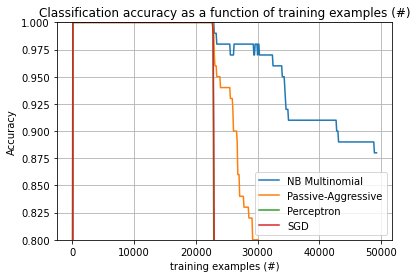

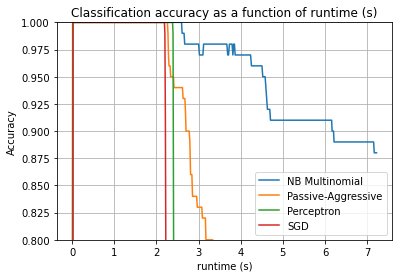

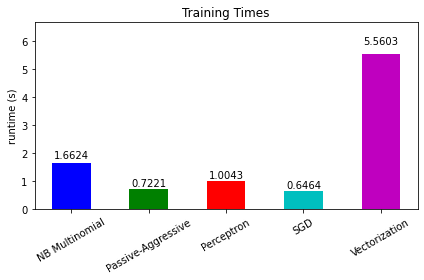

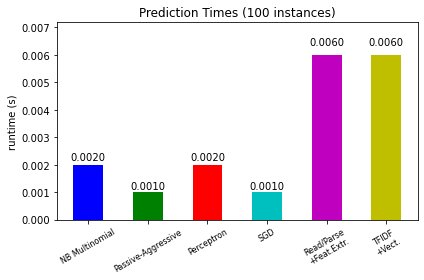

In [ ]:
from matplotlib import rcParams
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)


rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats['total_fit_time']
               for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('TFIDF\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show()

Partial fit classifier models on feature extracteds dataset (df_kw)

In [ ]:
df_data_new = pd.read_csv(directory_location + '/df_data_new.txt', sep = '\n', header = None)

In [ ]:
df_data_new

,0
0,0.0 0.0 0.0 0.0 0.0
1,0.0 0.0 0.0 0.0 0.0
2,0.0 0.0 0.0 0.0 0.0
3,0.0 0.0 0.0 0.0 0.0
4,0.0 0.0 0.0 0.0 0.0
...,...
49441,0.0 0.0 0.0 0.0 0.0
49442,0.0 0.0 0.0 0.0 0.0
49443,0.0 0.0 0.0 0.0 0.0
49444,0.0 0.0 0.0 0.0 1.0


In [ ]:
df_data_new = df_data_new[0]

In [ ]:
df_data_new

0        0.0 0.0 0.0 0.0 0.0
1        0.0 0.0 0.0 0.0 0.0
2        0.0 0.0 0.0 0.0 0.0
3        0.0 0.0 0.0 0.0 0.0
4        0.0 0.0 0.0 0.0 0.0
                ...         
49441    0.0 0.0 0.0 0.0 0.0
49442    0.0 0.0 0.0 0.0 0.0
49443    0.0 0.0 0.0 0.0 0.0
49444    0.0 0.0 0.0 0.0 1.0
49445    0.0 0.0 0.0 0.0 0.0
Name: 0, Length: 49446, dtype: object

In [ ]:
#m = [lemmatizer.lemmatize(list_num) for list_num in df_kw_csv]
#m = [stemmer.stem(list_num) for list_num in df_data_new]

In [ ]:
#m[0] #lemmatized and stemmed

'0.0 0.0 0.0 0.0 0.0'

In [ ]:
def stream_documents(df_data_new):
    global m
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    for doc_num in range(len(df_data_new)):
        m = re.search(r'(\d)\s(.+)', df_data_new[doc_num])
        cls, body = m.group(1), m.group(2)
        shortword = re.compile(r'\W*\b\w{1,2}\b')
        body = shortword.sub("", body)
        body = body.replace(";", " ")
        doc = {'cls': cls, 'body': body}
        yield doc

In [ ]:
stream_documents(df_data_new)

<generator object stream_documents at 0x0000025C9E1C6B30>

In [ ]:
data_stream = stream_documents(df_data_new)
all_classes = np.array([0,1])
pos_class = '1'

In [ ]:
#generate minibatch
def get_minibatch(doc_iter, size, pos_class=pos_class):
    data = [(doc['body'], pos_class not in doc['cls']) 
            for doc in itertools.islice(doc_iter, size)
           if doc['cls']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)

def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

In [ ]:
# test data statistics
#vectorizer = HashingVectorizer()
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 100
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 100)
parsing_time = time.time() - tick
tick = time.time()
X_test = tv_binary.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))

Test set is 100 documents (100 positive)


In [ ]:
y_test #

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}

In [ ]:
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

minibatch_size = 100

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = tv_binary.transform(X_train_text) #vectorized
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

                 SGD classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.01s (12532 docs/s)
          Perceptron classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.01s ( 8352 docs/s)
      NB Multinomial classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.02s ( 6265 docs/s)
  Passive-Aggressive classifier : 	   100 train docs (   100 positive)    100 test docs (   100 positive) accuracy: 0.000 in 0.02s ( 5569 docs/s)


                 SGD classifier : 	   400 train docs (   400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.05s ( 7426 docs/s)
          Perceptron classifier : 	   400 train docs (   400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.06s ( 7036 docs/s)
      NB Multinomial classifier : 	   400 train docs (   400 positive)    100 test docs (   100 positive) accuracy: 1.000 

          Perceptron classifier : 	  5800 train docs (  5800 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.75s ( 7692 docs/s)
      NB Multinomial classifier : 	  5800 train docs (  5800 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.76s ( 7641 docs/s)
  Passive-Aggressive classifier : 	  5800 train docs (  5800 positive)    100 test docs (   100 positive) accuracy: 0.000 in 0.76s ( 7621 docs/s)


                 SGD classifier : 	  6100 train docs (  6100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.79s ( 7732 docs/s)
          Perceptron classifier : 	  6100 train docs (  6100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.79s ( 7712 docs/s)
      NB Multinomial classifier : 	  6100 train docs (  6100 positive)    100 test docs (   100 positive) accuracy: 1.000 in 0.80s ( 7654 docs/s)
  Passive-Aggressive classifier : 	  6100 train docs (  6100 positive)    100 test docs (   100 positive) accuracy: 0.000 

          Perceptron classifier : 	 10300 train docs ( 10300 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.18s ( 8759 docs/s)
      NB Multinomial classifier : 	 10300 train docs ( 10300 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.18s ( 8729 docs/s)
  Passive-Aggressive classifier : 	 10300 train docs ( 10300 positive)    100 test docs (   100 positive) accuracy: 0.000 in 1.18s ( 8715 docs/s)


                 SGD classifier : 	 10600 train docs ( 10600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.21s ( 8769 docs/s)
          Perceptron classifier : 	 10600 train docs ( 10600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.21s ( 8754 docs/s)
      NB Multinomial classifier : 	 10600 train docs ( 10600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.21s ( 8726 docs/s)
  Passive-Aggressive classifier : 	 10600 train docs ( 10600 positive)    100 test docs (   100 positive) accuracy: 0.000 

      NB Multinomial classifier : 	 15400 train docs ( 15400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.71s ( 8982 docs/s)
  Passive-Aggressive classifier : 	 15400 train docs ( 15400 positive)    100 test docs (   100 positive) accuracy: 0.000 in 1.72s ( 8972 docs/s)


                 SGD classifier : 	 15700 train docs ( 15700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.73s ( 9052 docs/s)
          Perceptron classifier : 	 15700 train docs ( 15700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.74s ( 9041 docs/s)
      NB Multinomial classifier : 	 15700 train docs ( 15700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 1.74s ( 9031 docs/s)
  Passive-Aggressive classifier : 	 15700 train docs ( 15700 positive)    100 test docs (   100 positive) accuracy: 0.000 in 1.74s ( 9021 docs/s)


                 SGD classifier : 	 16000 train docs ( 16000 positive)    100 test docs (   100 positive) accuracy: 1.00

      NB Multinomial classifier : 	 20200 train docs ( 20200 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.16s ( 9372 docs/s)
  Passive-Aggressive classifier : 	 20200 train docs ( 20200 positive)    100 test docs (   100 positive) accuracy: 0.000 in 2.16s ( 9363 docs/s)


                 SGD classifier : 	 20500 train docs ( 20500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.18s ( 9415 docs/s)
          Perceptron classifier : 	 20500 train docs ( 20500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.18s ( 9402 docs/s)
      NB Multinomial classifier : 	 20500 train docs ( 20500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.18s ( 9385 docs/s)
  Passive-Aggressive classifier : 	 20500 train docs ( 20500 positive)    100 test docs (   100 positive) accuracy: 0.000 in 2.19s ( 9377 docs/s)


                 SGD classifier : 	 20800 train docs ( 20800 positive)    100 test docs (   100 positive) accuracy: 1.00

                 SGD classifier : 	 25600 train docs ( 25600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.69s ( 9517 docs/s)
          Perceptron classifier : 	 25600 train docs ( 25600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.69s ( 9510 docs/s)
      NB Multinomial classifier : 	 25600 train docs ( 25600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.70s ( 9496 docs/s)
  Passive-Aggressive classifier : 	 25600 train docs ( 25600 positive)    100 test docs (   100 positive) accuracy: 0.000 in 2.70s ( 9485 docs/s)


                 SGD classifier : 	 25900 train docs ( 25900 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.72s ( 9530 docs/s)
          Perceptron classifier : 	 25900 train docs ( 25900 positive)    100 test docs (   100 positive) accuracy: 1.000 in 2.72s ( 9523 docs/s)
      NB Multinomial classifier : 	 25900 train docs ( 25900 positive)    100 test docs (   100 positive) accuracy: 1.000 

                 SGD classifier : 	 30400 train docs ( 30400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.15s ( 9645 docs/s)
          Perceptron classifier : 	 30400 train docs ( 30400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.15s ( 9639 docs/s)
      NB Multinomial classifier : 	 30400 train docs ( 30400 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.16s ( 9630 docs/s)
  Passive-Aggressive classifier : 	 30400 train docs ( 30400 positive)    100 test docs (   100 positive) accuracy: 0.000 in 3.16s ( 9624 docs/s)


                 SGD classifier : 	 30700 train docs ( 30700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.19s ( 9634 docs/s)
          Perceptron classifier : 	 30700 train docs ( 30700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.19s ( 9625 docs/s)
      NB Multinomial classifier : 	 30700 train docs ( 30700 positive)    100 test docs (   100 positive) accuracy: 1.000 

          Perceptron classifier : 	 35500 train docs ( 35500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.66s ( 9706 docs/s)
      NB Multinomial classifier : 	 35500 train docs ( 35500 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.66s ( 9696 docs/s)
  Passive-Aggressive classifier : 	 35500 train docs ( 35500 positive)    100 test docs (   100 positive) accuracy: 0.000 in 3.66s ( 9693 docs/s)


                 SGD classifier : 	 35800 train docs ( 35800 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.68s ( 9717 docs/s)
          Perceptron classifier : 	 35800 train docs ( 35800 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.69s ( 9712 docs/s)
      NB Multinomial classifier : 	 35800 train docs ( 35800 positive)    100 test docs (   100 positive) accuracy: 1.000 in 3.69s ( 9704 docs/s)
  Passive-Aggressive classifier : 	 35800 train docs ( 35800 positive)    100 test docs (   100 positive) accuracy: 0.000 

  Passive-Aggressive classifier : 	 40300 train docs ( 40300 positive)    100 test docs (   100 positive) accuracy: 0.000 in 4.11s ( 9814 docs/s)


                 SGD classifier : 	 40600 train docs ( 40600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.12s ( 9844 docs/s)
          Perceptron classifier : 	 40600 train docs ( 40600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.13s ( 9840 docs/s)
      NB Multinomial classifier : 	 40600 train docs ( 40600 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.13s ( 9835 docs/s)
  Passive-Aggressive classifier : 	 40600 train docs ( 40600 positive)    100 test docs (   100 positive) accuracy: 0.000 in 4.13s ( 9830 docs/s)


                 SGD classifier : 	 40900 train docs ( 40900 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.15s ( 9858 docs/s)
          Perceptron classifier : 	 40900 train docs ( 40900 positive)    100 test docs (   100 positive) accuracy: 1.00

  Passive-Aggressive classifier : 	 45400 train docs ( 45400 positive)    100 test docs (   100 positive) accuracy: 0.000 in 4.62s ( 9823 docs/s)


                 SGD classifier : 	 45700 train docs ( 45700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.65s ( 9824 docs/s)
          Perceptron classifier : 	 45700 train docs ( 45700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.65s ( 9820 docs/s)
      NB Multinomial classifier : 	 45700 train docs ( 45700 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.66s ( 9812 docs/s)
  Passive-Aggressive classifier : 	 45700 train docs ( 45700 positive)    100 test docs (   100 positive) accuracy: 0.000 in 4.66s ( 9807 docs/s)


                 SGD classifier : 	 46000 train docs ( 46000 positive)    100 test docs (   100 positive) accuracy: 1.000 in 4.69s ( 9807 docs/s)
          Perceptron classifier : 	 46000 train docs ( 46000 positive)    100 test docs (   100 positive) accuracy: 1.00

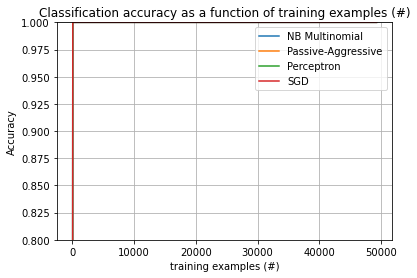

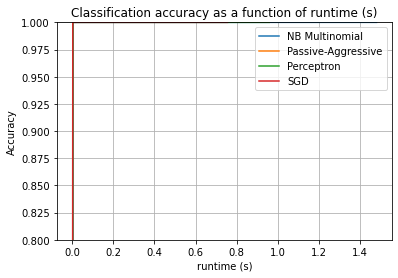

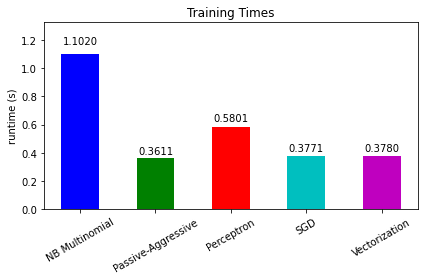

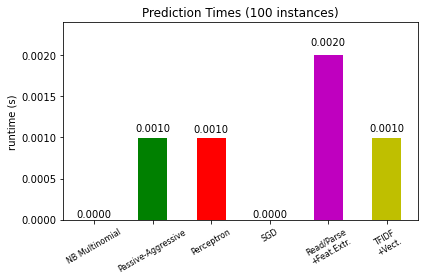

In [ ]:
from matplotlib import rcParams
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)


rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats['total_fit_time']
               for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('TFIDF\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show() #wierd looking bc so many words are dropped